In [149]:
ors = 3

In [150]:
import sys
sys.path.append('../_amigocloud')
import simplekml
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
import os

In [151]:
# RUTA ONEDRIVE
ruta_data = r'G:'
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

# leer los dos shps de siembra y puntos de planificacion
path_cat = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\catastro_S09_MIERCOLES.shp'
path_puntos = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PUNTOS_PLAN.shp'
path_plan = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PLANIFICACION.shp'
path_xlsx_parte = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\parte_diario_pulverizacion.xlsx'

# ACTUALIZAR SHP PLANIFICACION

In [152]:
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

In [153]:
# filtrar la semana de interes
gdf_puntos_select = gdf_puntos[gdf_puntos['os'] == ors]
gdf_puntos_sem = gdf_puntos_select.copy()
#quita caracteres especiales
gdf_puntos_sem['unidad_04'] = gdf_puntos_sem['unidad_04'].str.replace(r'[\r\n\t]', '', regex=True)
gdf_puntos_sem

,unidad_03,unidad_04,os,obs,procesado,geometry
2,1530,C.I.T.T.C.A.,3,None,None,"MULTIPOINT (487150.962 8094305.938, 487481.692..."


In [154]:
multipoint_gdf = gdf_puntos_sem.copy()

In [155]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [156]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,obs,procesado,geometry
2,1530,C.I.T.T.C.A.,3,None,None,POINT (487150.962 8094305.938)
2,1530,C.I.T.T.C.A.,3,None,None,POINT (487481.692 8093995.052)
2,1530,C.I.T.T.C.A.,3,None,None,POINT (487785.963 8094405.157)
2,1530,C.I.T.T.C.A.,3,None,None,POINT (487852.109 8094907.866)
2,1530,C.I.T.T.C.A.,3,None,None,POINT (487938.099 8093793.307)


<Axes: >

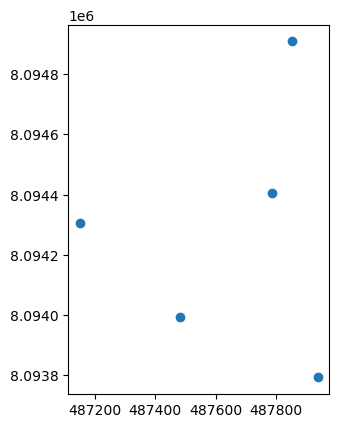

In [157]:
puntos_indi.plot()

In [158]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]

In [159]:
# Cambiar el nombre de la columna 'old_name' a 'new_name'
poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)

In [160]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
7557,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L3,14.046489,0.0,50,"POLYGON ((487193.395 8094028.850, 487262.759 8..."
7558,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L4,16.907230,0.0,50,"POLYGON ((487326.883 8094631.099, 487256.226 8..."
7560,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L2,8.892186,0.0,50,"POLYGON ((487789.363 8093979.038, 487947.338 8..."
7562,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L1,48.404143,0.0,50,"POLYGON ((487345.806 8094635.527, 488024.724 8..."
7564,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L5,12.004987,0.0,50,"POLYGON ((488023.791 8094765.791, 487704.816 8..."


In [161]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [162]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
7557,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L3,14.046489,0.0,50,"POLYGON ((487193.395 8094028.850, 487262.759 8..."
7558,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L4,16.907230,0.0,50,"POLYGON ((487326.883 8094631.099, 487256.226 8..."
7560,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L2,8.892186,0.0,50,"POLYGON ((487789.363 8093979.038, 487947.338 8..."
7562,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L1,48.404143,0.0,50,"POLYGON ((487345.806 8094635.527, 488024.724 8..."
7564,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L5,12.004987,0.0,50,"POLYGON ((488023.791 8094765.791, 487704.816 8..."


In [163]:
# agrega los campos faltantes
poligonos_intersect_cat['os'] = ors

In [164]:
plan = poligonos_intersect_cat.copy()

In [165]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os
7557,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L3,14.046489,0.0,50,"POLYGON ((487193.395 8094028.850, 487262.759 8...",3
7558,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L4,16.907230,0.0,50,"POLYGON ((487326.883 8094631.099, 487256.226 8...",3
7560,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L2,8.892186,0.0,50,"POLYGON ((487789.363 8093979.038, 487947.338 8...",3
7562,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L1,48.404143,0.0,50,"POLYGON ((487345.806 8094635.527, 488024.724 8...",3
7564,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L5,12.004987,0.0,50,"POLYGON ((488023.791 8094765.791, 487704.816 8...",3


<Axes: >

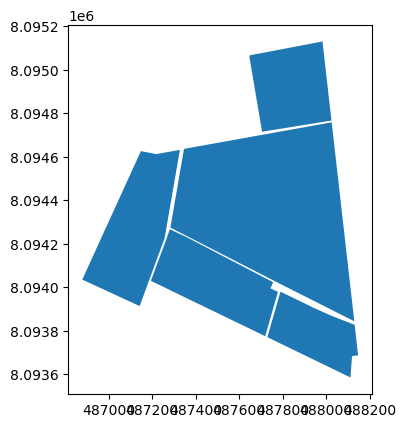

In [166]:
plan.plot()

In [167]:
plan['area'].sum()

100.25503450533392

In [168]:
#RECALCULAR EL AREA
plan['area'] = plan.geometry.area / 10000

In [169]:
plan['area'].sum()

100.25503450533391

In [170]:
# carga el shp de planificacion
gdf_plan = gpd.read_file(path_plan)

In [171]:
# determina el ultimo id
last_id = 0
if gdf_plan['id'].max() > 0:
    last_id = gdf_plan['id'].max()
else:
    last_id = 0

In [172]:
last_id

27

In [173]:
# Asignar valores incrementales a la columna 'id' empezando desde last_id + 1
plan['id'] = range(last_id + 1, last_id + 1 + len(plan))

In [174]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
7557,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L3,14.046489,0.0,50,"POLYGON ((487193.395 8094028.850, 487262.759 8...",3,28
7558,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L4,16.907230,0.0,50,"POLYGON ((487326.883 8094631.099, 487256.226 8...",3,29
7560,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L2,8.892186,0.0,50,"POLYGON ((487789.363 8093979.038, 487947.338 8...",3,30
7562,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L1,48.404143,0.0,50,"POLYGON ((487345.806 8094635.527, 488024.724 8...",3,31
7564,577.0,SAN ANTONIO--IAG,1530.0,C.I.T.T.C.A.,L5,12.004987,0.0,50,"POLYGON ((488023.791 8094765.791, 487704.816 8...",3,32


In [175]:
len(plan)

5

In [176]:
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)

In [177]:
gdf_pla_gral['area'].sum()

640.0553997126

In [178]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [179]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,os,soca,id,inst,idd,geometry
0,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L31,30.260942,1,2,1,50,None,"POLYGON ((504085.659 8094406.031, 503737.808 8..."
1,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L16,23.216246,1,4,2,50,None,"POLYGON ((504352.053 8094797.970, 504272.088 8..."
2,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L6,19.683505,1,5,3,50,None,"POLYGON ((503260.583 8094596.306, 503714.735 8..."
3,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L35,7.795719,1,4,4,50,None,"POLYGON ((504693.348 8094607.629, 504673.327 8..."
4,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L34,7.048921,1,5,5,50,None,"POLYGON ((504137.327 8094415.183, 504648.080 8..."
5,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L5,10.318332,1,5,6,50,None,"POLYGON ((502800.712 8094558.618, 502817.481 8..."
6,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L9,26.783587,1,3,7,50,None,"POLYGON ((502151.946 8095089.317, 502180.927 8..."
7,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L15,17.950658,1,2,8,50,None,"POLYGON ((501079.860 8094856.577, 501419.672 8..."
8,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L7,15.371285,1,2,9,50,None,"POLYGON ((501510.045 8095556.280, 501495.788 8..."
9,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L10,26.586339,1,2,10,50,None,"POLYGON ((502549.761 8095663.451, 503187.898 8..."


In [180]:
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

# CARGAR PLANIFICACION A AMIGOCLOUD

In [181]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [182]:
# repreyectar a WGS84
gdf_pla_gral = plan.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
gdf_pla_gral['geometry'] = gdf_pla_gral['geometry'].apply(convertir_a_multipolygon)

In [183]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [184]:
len(gdf_pla_gral)

5

In [185]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/35248/sql'
for index, row in gdf_pla_gral.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_360912 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, os, geometry)
    VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CARGAR XLSX

In [186]:
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime

In [187]:
# Cargar el archivo Excel
sheet_name = 'DATA'
table_name = 'tbl_data'

In [188]:
excel_data = pd.read_excel(path_xlsx_parte)

In [189]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
7557,577,SAN ANTONIO--IAG,1530,C.I.T.T.C.A.,L3,14.046489,0,50,"MULTIPOLYGON (((-63.12047 -17.23875, -63.11981...",3,28
7558,577,SAN ANTONIO--IAG,1530,C.I.T.T.C.A.,L4,16.907230,0,50,"MULTIPOLYGON (((-63.11921 -17.23331, -63.11988...",3,29
7560,577,SAN ANTONIO--IAG,1530,C.I.T.T.C.A.,L2,8.892186,0,50,"MULTIPOLYGON (((-63.11486 -17.23920, -63.11338...",3,30
7562,577,SAN ANTONIO--IAG,1530,C.I.T.T.C.A.,L1,48.404143,0,50,"MULTIPOLYGON (((-63.11903 -17.23327, -63.11264...",3,31
7564,577,SAN ANTONIO--IAG,1530,C.I.T.T.C.A.,L5,12.004987,0,50,"MULTIPOLYGON (((-63.11265 -17.23209, -63.11565...",3,32


In [190]:
new_data = {
    'INSTITUCION':list(gdf_pla_gral['inst']), 
    'COD CANERO': list(gdf_pla_gral['unidad_03']),
    'NOMBRE CANERO': list(gdf_pla_gral['unidad_04']),
    'COD PROPIEDAD': list(gdf_pla_gral['unidad_01']),
    'NOMBRE PROPIEDAD': list(gdf_pla_gral['unidad_02']),
    'LOTE': list(gdf_pla_gral['unidad_05']),
    'HECTAREA': list(gdf_pla_gral['area']),
    'CICLO': list(gdf_pla_gral['soca']),
    'ID': list(gdf_pla_gral['id']),
    'OS': list(gdf_pla_gral['os'])
}

new_df = pd.DataFrame(new_data)

In [191]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS
0,50,1530,C.I.T.T.C.A.,577,SAN ANTONIO--IAG,L3,14.046489,0,28,3
1,50,1530,C.I.T.T.C.A.,577,SAN ANTONIO--IAG,L4,16.907230,0,29,3
2,50,1530,C.I.T.T.C.A.,577,SAN ANTONIO--IAG,L2,8.892186,0,30,3
3,50,1530,C.I.T.T.C.A.,577,SAN ANTONIO--IAG,L1,48.404143,0,31,3
4,50,1530,C.I.T.T.C.A.,577,SAN ANTONIO--IAG,L5,12.004987,0,32,3


In [192]:
new_df['MEZCLA'] = 0
new_df['LABOR_REALIZADA'] = 'PUL. CON DRONE'
new_df['Nº DE LABOR'] = 'PA-2025-1'

In [193]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS,MEZCLA,LABOR_REALIZADA,Nº DE LABOR
0,50,1530,C.I.T.T.C.A.,577,SAN ANTONIO--IAG,L3,14.046489,0,28,3,0,PUL. CON DRONE,PA-2025-1
1,50,1530,C.I.T.T.C.A.,577,SAN ANTONIO--IAG,L4,16.907230,0,29,3,0,PUL. CON DRONE,PA-2025-1
2,50,1530,C.I.T.T.C.A.,577,SAN ANTONIO--IAG,L2,8.892186,0,30,3,0,PUL. CON DRONE,PA-2025-1
3,50,1530,C.I.T.T.C.A.,577,SAN ANTONIO--IAG,L1,48.404143,0,31,3,0,PUL. CON DRONE,PA-2025-1
4,50,1530,C.I.T.T.C.A.,577,SAN ANTONIO--IAG,L5,12.004987,0,32,3,0,PUL. CON DRONE,PA-2025-1


In [194]:
final_data = pd.concat([excel_data, new_df], ignore_index=True)

In [195]:
final_data.to_excel(path_xlsx_parte, index=False)